# Time forecasting for solar energy using a GRU architecture

---

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import tensorflow as tf
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Dropout, Conv2D, Conv1D, MaxPooling3D, MaxPooling2D
from keras.layers import Flatten, LSTM, Lambda, Reshape, BatchNormalization, GRU, AveragePooling2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras.optimizers as ops

2023-06-30 18:59:58.232699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


To clean the data by deleting the features not to be used, and group the data by days.

In [2]:
def fixData(df):
    df = df.drop(df.index[[0,1,2]])
    df = df.drop('MW', axis=1)
    df.columns = ['Date', 'From', 'to', 'MW']
    
    dates = df['Date'].tolist()

    days = []
    months = []
    years = []
    for date in dates:
        days.append(date.split('.')[0])
        months.append(date.split('.')[1])
        years.append(date.split('.')[2])

    df['Day'] = days
    df['Month'] = months
    df['Year'] = years
    
    def fixMW(cols):
        TT = cols
        TT = TT.replace('.','')
        TT = TT.replace(',','.')
        return TT

    df['MW'] = df['MW'].apply(fixMW).astype(float)
    df['Day'] = df['Day'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Year'] = df['Year'].astype(int)
    
    df = df.groupby(['Year','Month','Day'])['MW'].sum()
    df = pd.DataFrame(df)
    df['Month'] = df.index.get_level_values('Month') 
    df['Day'] = df.index.get_level_values('Day') 
    df['Year'] = df.index.get_level_values('Year') 
    df.reset_index(drop=True, inplace=True)
    return df

# Xplot function :
**A function that draws the learning curves.**

In [3]:
def Xplot(hist):
    f, axarr = plt.subplots(1,1, figsize=(20, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Train', 'val'], loc='upper left')
    plt.show()

## Function visualiser  :

In [4]:
def visualiser(df):   
    f, axarr = plt.subplots(1,1, figsize=(20, 5))    
    df = df.drop('Month', axis=1)
    df = df.drop('Day', axis=1)
    df = df.drop('Year', axis=1)    
    df = df.values
    df = df.astype('float32')   
    plt.plot(df)
    plt.show()   
    return df

**This function is used to separate the training and test data.**

In [5]:
def split1(df):
    train_size = int(len(df) * 0.75)
    test_size = len(df) - train_size
    train, test = df[0:train_size,:], df[train_size:len(df),:]
    return train, test

def split2(df, look_back=7):
	dataX, dataY = [], []
	for i in range(len(df)-look_back-1):
		a = df[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# Load the data

In [6]:
Data1 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2010.csv',sep=';')
Data2 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2011.csv',sep=';')
Data3 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2012.csv',sep=';')
Data4 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2013.csv',sep=';')
Data5 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2014.csv',sep=';')
Data6 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2015.csv',sep=';')
Data7 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2016.csv',sep=';')
Data8 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2017.csv',sep=';')
Data9 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2018.csv',sep=';')
Data10 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2019.csv',sep=';')

Data1 = fixData(Data1)
Data2 = fixData(Data2)
Data3 = fixData(Data3)
Data4 = fixData(Data4)
Data5 = fixData(Data5)
Data6 = fixData(Data6)
Data7 = fixData(Data7)
Data8 = fixData(Data8)
Data9 = fixData(Data9)
Data10 = fixData(Data10)

Data = pd.concat([Data1, Data2, Data3, Data4, Data5, Data6, Data7, Data8, Data9, Data10], ignore_index=True)

Data.head()

,MW,Month,Day,Year
0,332.0,1,1,2010
1,322.0,1,2,2010
2,163.0,1,3,2010
3,103.0,1,4,2010
4,165.0,1,5,2010


In [7]:
Data[(Data['Month'] == 1) & (Data['Year'] == 2010)]

,MW,Month,Day,Year
0,332.0,1,1,2010
1,322.0,1,2,2010
2,163.0,1,3,2010
3,103.0,1,4,2010
4,165.0,1,5,2010
5,124.0,1,6,2010
6,156.0,1,7,2010
7,120.0,1,8,2010
8,88.0,1,9,2010
9,67.0,1,10,2010


# Data mining

Visualize data:


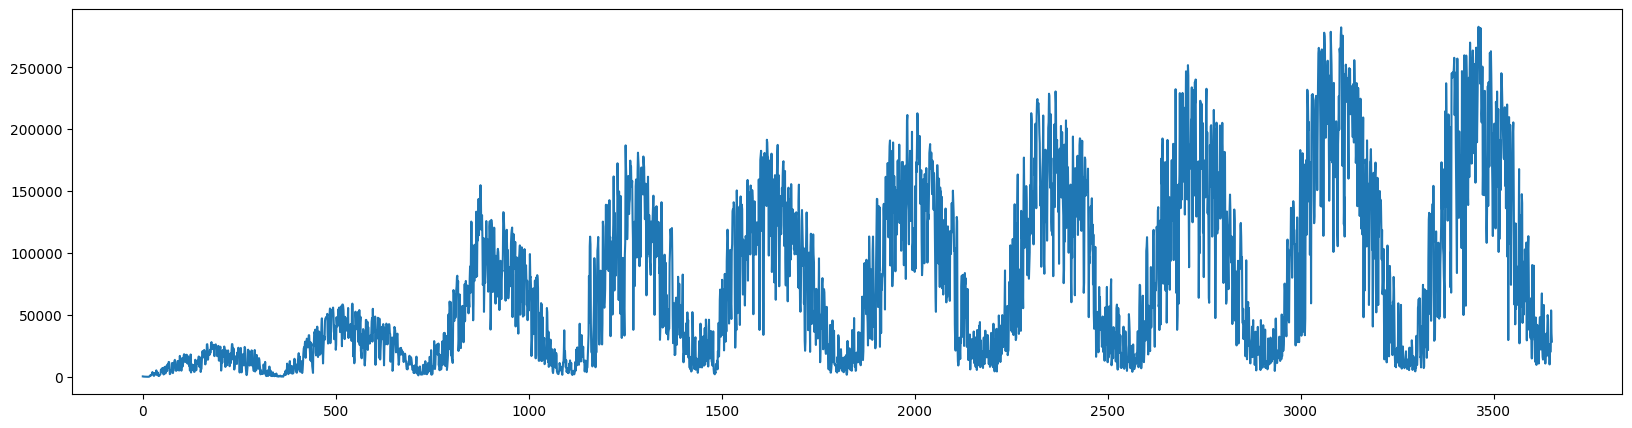

In [8]:
Data0 = Data
Data0 = visualiser(Data0)

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
Data0 = scaler.fit_transform(Data0)

# Separation of training and test data
**Use of split1 and split2 to separate training and test data.**


In [10]:
train, test = split1(Data0)

In [11]:
trainX, trainY = split2(train)
testX, testY = split2(test)

In [12]:
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

# The creation of the model

In [13]:
model = Sequential()
model.add(GRU(units = 8, input_shape=(trainX.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units = 16))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = ops.Nadam(lr=1e-3), loss = 'mse')

model.summary()

2023-06-30 19:01:10.149016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7, 8)              264       
                                                                 
 dropout (Dropout)           (None, 7, 8)              0         
                                                                 
 gru_1 (GRU)                 (None, 16)                1248      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1,529
Trainable params: 1,529
Non-trainable params: 0
_________________________________________________________________


/Users/nyussay/Library/Python/3.8/lib/python/site-packages/keras/optimizers/optimizer_v2/nadam.py:89: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# The training of the model

In [14]:
history = model.fit(trainX, trainY, validation_split=0.2, epochs=100, batch_size=8, verbose=1)

Epoch 1/100
273/273 [==============================] - 9s 14ms/step - loss: 0.0329 - val_loss: 0.0172
Epoch 2/100
273/273 [==============================] - 3s 10ms/step - loss: 0.0096 - val_loss: 0.0171
Epoch 3/100
273/273 [==============================] - 3s 12ms/step - loss: 0.0088 - val_loss: 0.0165
Epoch 4/100
273/273 [==============================] - 2s 9ms/step - loss: 0.0086 - val_loss: 0.0164
Epoch 5/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0081 - val_loss: 0.0195
Epoch 6/100
273/273 [==============================] - 2s 9ms/step - loss: 0.0081 - val_loss: 0.0167
Epoch 7/100
273/273 [==============================] - 3s 9ms/step - loss: 0.0081 - val_loss: 0.0164
Epoch 8/100
273/273 [==============================] - 3s 10ms/step - loss: 0.0079 - val_loss: 0.0180
Epoch 9/100
273/273 [==============================] - 3s 10ms/step - loss: 0.0077 - val_loss: 0.0160
Epoch 10/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0075 - v

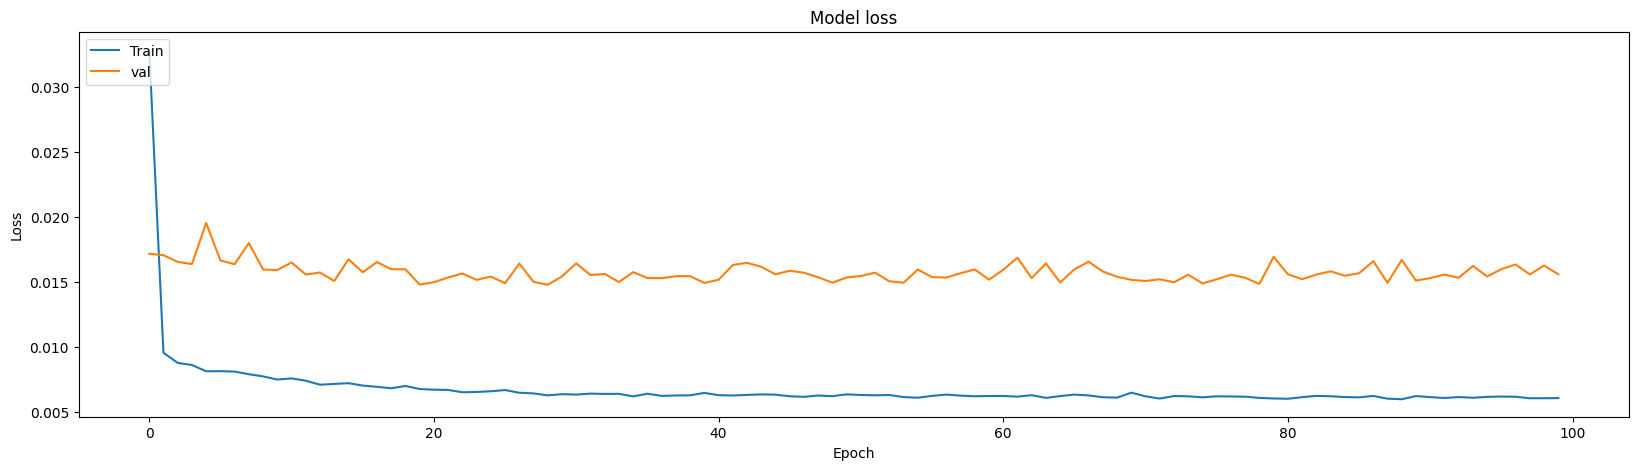

In [15]:
Xplot(history)

# Prediction on the test data
Now let's try our model on the test data and see what it will give.

29/29 [==============================] - 0s 3ms/step
Train Score: 24616.96 RMSE
Test Score: 42115.95 RMSE


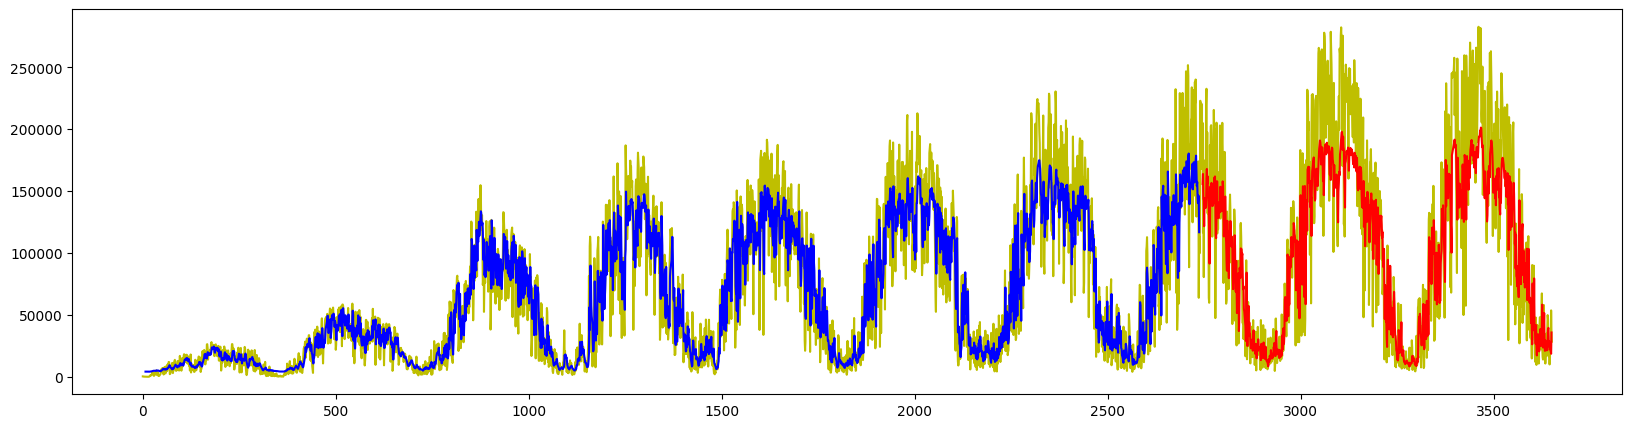

In [16]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

scaler2 = MinMaxScaler()
scaler2.min_, scaler2.scale_ = scaler.min_[0], scaler.scale_[0]

trainPredict = scaler2.inverse_transform(trainPredict)
trainYp = scaler2.inverse_transform([trainY])
testPredict = scaler2.inverse_transform(testPredict)
testYp = scaler2.inverse_transform([testY])

from pylab import rcParams
rcParams['figure.figsize'] = 20, 5


import math
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYp[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYp[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(Data0)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[7:len(trainPredict)+7, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(Data0)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(7*2)+1:len(Data0)-1, :] = testPredict
# plot baseline and predictions

plt.plot(scaler.inverse_transform(Data0), color='y')
plt.plot(trainPredictPlot, color='b')
plt.plot(testPredictPlot , color='r')
plt.show()



*   **Train Score: 26332.25 RMSE**
*   **Test Score: 45982.77 RMSE**


In [17]:
#df = pd.DataFrame(trainPredict)
column_names = ['MW Total']
df = pd.DataFrame(trainPredict, columns=column_names)
print(df)

           MW Total
0       4197.135254
1       4187.685059
2       4178.399902
3       4174.173340
4       4169.882812
...             ...
2726  145268.375000
2727  140341.203125
2728  146397.187500
2729  145814.437500
2730  116798.882812

[2731 rows x 1 columns]


In [18]:
df = pd.DataFrame(trainPredict[:30])


print('\nIn this months high production is expexted in the next days:')
print(df.nlargest(5, 0).index.tolist())
print('\nSuggest to use electric devices')

print('\nIn this months low production is expexted in the next days:')
print(df.nsmallest(5, 0).index.tolist())
print('\nSuggest to not use electric devices')


In this months high production is expexted in the next days:
[29, 24, 21, 20, 27]

Suggest to use electric devices

In this months low production is expexted in the next days:
[8, 10, 7, 9, 6]

Suggest to not use electric devices


In [19]:
import csv
start_time = ''
end_time = ''
with open('21_01_2019.csv', 'r') as f:
    reader = csv.reader(f, delimiter=';')
    next(reader)
    for row in reader:
        date = row[0]
        time = row[1]
        amount = int(row[3])
        if amount > 20:
            if not start_time:
                start_time = time
                end_time = time
            else:
                end_time = time
        elif start_time:
            print('Prefered time for using electricity tomorrow is from', start_time, 'to', end_time)
            start_time = ''
            end_time = ''

Prefered time for using electricity tomorrow is from 09:30 to 14:30
